# Data Pre Processing
Data is often taken from multiple sources and simply unrealistic to expect that the can be used immidiately. Let go throug an example to learn more.

Data in this notebook has been used for Power Laws: Cold Start Energy Forecasting competition. The data can be downloaded in the link below.

https://shop.exchange.se.com/en-US/apps/39021/forecasting-cold-start-building-energy-consumption

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cold-start/cold-start-test.csv
/kaggle/input/cold-start/train.csv
/kaggle/input/cold-start/meta.csv
/kaggle/input/cold-start/submission-format.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv


In [2]:
# main libraries
import pandas as pd
import numpy as np
import time# visual libraries
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
plt.style.use('ggplot')# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
#from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#check Path
from pathlib import Path

In [3]:
"""
Check the current working directory and creating a path to the data folder

"""
print(Path.cwd())
parent_dir = os.chdir('/kaggle/')
print(os.listdir("../kaggle/input"))
data_dir = Path.cwd() /'input/cold-start'

/kaggle/working
['cold-start', 'hourly-energy-consumption']


In [4]:
'''Read the data in the CSV file using pandas''' 
df = pd.read_csv(data_dir/'train.csv')
df.head()

,series_id;timestamp;consumption;temperature
0,100822;2017-09-26T12:00:00+02:00;37661.0154062...
1,102728;2014-12-13T19:00:00+01:00;226493.710676...
2,102728;2014-12-18T01:00:00+01:00;255101.677614...
3,102728;2014-12-20T20:00:00+01:00;236639.954613...
4,101516;2017-08-30T03:00:00+02:00;195996.175161...


> The data in the CSV file is the text file and separate by a semicolon. We need to separate these into different column. 

In [5]:
df = pd.read_csv(data_dir/'train.csv',sep=';')
df.head()

,series_id,timestamp,consumption,temperature
0,100822,2017-09-26T12:00:00+02:00,37661.015406,NaN
1,102728,2014-12-13T19:00:00+01:00,226493.710677,13.166667
2,102728,2014-12-18T01:00:00+01:00,255101.677614,11.650000
3,102728,2014-12-20T20:00:00+01:00,236639.954614,10.150000
4,101516,2017-08-30T03:00:00+02:00,195996.175161,NaN


In [6]:
'''size of the data set'''
df.shape

(509376, 4)

### Missing values :

Missing values is oftenly happen in your dataset and must be taken into consideration.

* Eliminate rows with missing data :Simple and sometimes effective strategy. Fails if many objects have missing values. If a feature has mostly missing values, then that feature itself can also be eliminated.
* Estimate missing values : If only a reasonable percentage of values are missing, then we can also run simple interpolation methods to fill in those values. However, most common method of dealing with missing values is by filling them in with the mean, median or mode value of the respective feature.


> **Missing values**

In [7]:
'''The null or NaN in the data set'''
df.isnull().any()

series_id      False
timestamp      False
consumption    False
temperature     True
dtype: bool

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509376 entries, 0 to 509375
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   series_id    509376 non-null  int64  
 1   timestamp    509376 non-null  object 
 2   consumption  509376 non-null  float64
 3   temperature  280687 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 15.5+ MB


In [9]:
'''This will display a summary statistics of all observed features and labels.'''
df.describe()

,series_id,consumption,temperature
count,509376.000000,5.093760e+05,280687.000000
mean,101851.234828,1.076238e+05,15.188679
std,1020.487674,1.626611e+05,8.987142
min,100003.000000,0.000000e+00,-13.466667
25%,100998.000000,1.542092e+04,8.451190
50%,101884.500000,4.986205e+04,15.163333
75%,102697.000000,1.351661e+05,21.800000
max,103634.000000,2.085109e+06,44.350000


In [10]:
#copy data frame(copying through variable will also change the previous data) using data frame copy instead
data = df.copy()

In [11]:
'''Eliminate or deleting Rows.'''
data.dropna(inplace = True)
#df.isnull().any()
data.isnull().any().sum()

0

In [12]:
df.shape,data.shape

((509376, 4), (280687, 4))

Replacing With Mean/Median/Mode
This strategy can be applied on a feature which has numeric data like the age of a person or the ticket fare. We can calculate the mean, median or mode of the feature and replace it with the missing values.

In [13]:
#df[''].isnull().any().sum()
data = df.copy()
data['temperature'].mean()
#data['temperature'].median()
#data['temperature'].mode()

15.188678691662805

In [14]:
data['temperature'].replace(np.NaN, data['temperature'].mean(),inplace=True)
#data.fillna(data.mean(), inplace=True)


In [15]:
data.head(),df.head()

(   series_id                  timestamp    consumption  temperature
 0     100822  2017-09-26T12:00:00+02:00   37661.015406    15.188679
 1     102728  2014-12-13T19:00:00+01:00  226493.710677    13.166667
 2     102728  2014-12-18T01:00:00+01:00  255101.677614    11.650000
 3     102728  2014-12-20T20:00:00+01:00  236639.954614    10.150000
 4     101516  2017-08-30T03:00:00+02:00  195996.175161    15.188679,
    series_id                  timestamp    consumption  temperature
 0     100822  2017-09-26T12:00:00+02:00   37661.015406          NaN
 1     102728  2014-12-13T19:00:00+01:00  226493.710677    13.166667
 2     102728  2014-12-18T01:00:00+01:00  255101.677614    11.650000
 3     102728  2014-12-20T20:00:00+01:00  236639.954614    10.150000
 4     101516  2017-08-30T03:00:00+02:00  195996.175161          NaN)

# Let try another example which using LSTM model to forecast energy consumption

In [16]:
"""
Check the current working directory and creating a path to the data folder
"""
print(Path.cwd())
parent_dir = os.chdir('/kaggle/')
print(os.listdir("../kaggle/input"))
data_dir = Path.cwd() /'input/hourly-energy-consumption'

/kaggle
['cold-start', 'hourly-energy-consumption']


In [17]:
'''Read the data in the CSV file''' 

pjme = pd.read_csv('../kaggle/input/hourly-energy-consumption/PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [18]:
'''print out the data'''
print(pjme)

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0

[145366 rows x 1 columns]


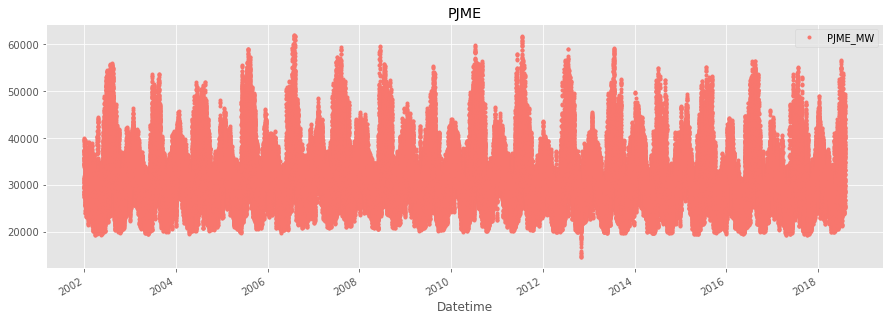

In [19]:
'''
Plot the energy consumption data
'''
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME')

In [20]:
'''
Prepare the train and test data by splitting the data set to before 2015 and after 2015
'''
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [21]:
'''
print out the trainning set
'''
print(pjme_train)

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2014-01-01 20:00:00  36193.0
2014-01-01 21:00:00  35601.0
2014-01-01 22:00:00  34242.0
2014-01-01 23:00:00  32215.0
2014-01-02 00:00:00  30159.0

[113927 rows x 1 columns]


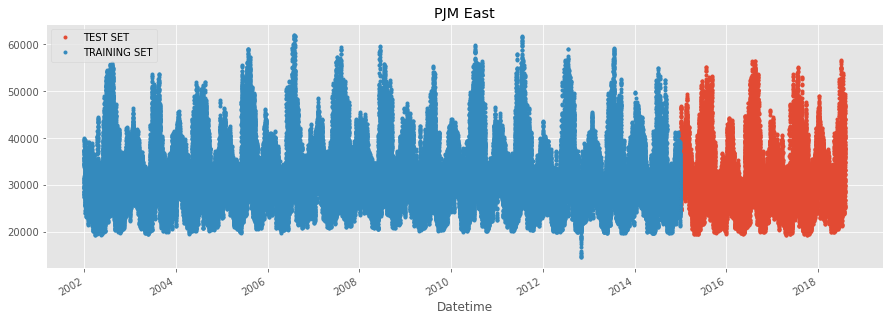

In [22]:
'''
plot the trainning set (blue) and test set (red)
'''
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [23]:
'''
Define the function to normalize the data
'''
from sklearn.preprocessing import MinMaxScaler

def normalize(data):
    scaler = MinMaxScaler()

    data = data.dropna()
    dataset = data.values
    dataset = dataset.astype('float32')
    data = scaler.fit_transform(dataset)
    return data

In [45]:
'''
Applied the normalization to train and test set
'''
train_data = normalize(pjme_train)
test_data = normalize(pjme_test)

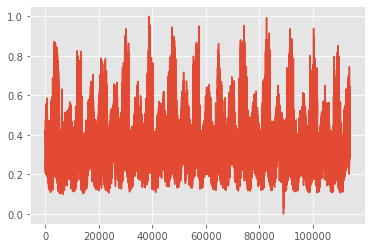

In [25]:
'''
plot the data after normalization
'''
plt.plot(train_data)

In [26]:
'''plt.figure(figsize=(15,6))
data_csv = pjme_train.dropna()
dataset = pjme_train.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))
plt.plot(dataset)'''

"plt.figure(figsize=(15,6))\ndata_csv = pjme_train.dropna()\ndataset = pjme_train.values\ndataset = dataset.astype('float32')\nmax_value = np.max(dataset)\nmin_value = np.min(dataset)\nscalar = max_value - min_value\ndataset = list(map(lambda x: (x-min_value) / scalar, dataset))\nplt.plot(dataset)"

In [36]:
#slower 
'''
train_data = list(train_data)
test_data  = list(test_data)

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
'''

In [50]:
#dataset = dataframe.values
#dataset = dataset.astype('float32')

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [40]:
print(len(train_data))
print(len(test_data))

113927
31439


In [53]:
look_back = 5
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test   = create_dataset(test_data, look_back)

The X=t and Y=t+5

In [54]:
print(X_train[0:5]), print(y_train[0:5])

[[0.2518487  0.22338563 0.2113136  0.20750028 0.2173391 ]
 [0.22338563 0.2113136  0.20750028 0.2173391  0.2460339 ]
 [0.2113136  0.20750028 0.2173391  0.2460339  0.29828292]
 [0.20750028 0.2173391  0.2460339  0.29828292 0.34033495]
 [0.2173391  0.2460339  0.29828292 0.34033495 0.3635521 ]]
[0.2460339  0.29828292 0.34033495 0.3635521  0.3753292 ]


(None, None)

In [55]:
X_train.shape, y_train.shape

((113921, 5), (113921,))

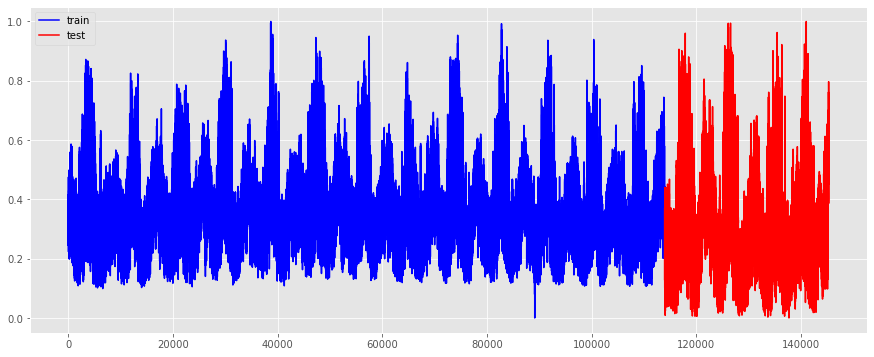

In [58]:
'''
plot train and test set.
'''
plt.figure(figsize=(15,6))
x1=np.arange(0,113921)
x2 = np.arange(113921,113921 + 31433)
plt.plot(x1,y_train,'b',label='train')
plt.plot(x2, y_test, 'r', label='test')
plt.legend(loc='best')

In [59]:
'''
X_train = X_train.reshape(-1, 1, look_back)
y_train = y_train.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, look_back)
'''

'\nX_train = X_train.reshape(-1, 1, look_back)\ny_train = y_train.reshape(-1, 1, 1)\nX_test = X_test.reshape(-1, 1, look_back)\n'

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint
import random
import sys
import io
from tqdm import tqdm
import tensorflow as tf

Using TensorFlow backend.


LSTMs are a subclass of recurrent neural networks. Recurrent neural nets are by definition applied on sequential data, which without loss of generality means data samples that change over time. A full history of a data sample is then described by the sample values over a finite time window, i.e. if your data live in an N-dimensional space and evolve over t-time steps, your input representation must be of shape (num_samples, t, N).

> The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].
> 
> Currently, the data is in the form: [samples, features]. Using numpy.reshape() to transform the input data into the right structure [samples, time steps, features].

In [65]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [67]:
X_train.shape, y_train.shape

((113921, 1, 5), (113921,))

Setup the model using keras and fit the data to the model.

In [80]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(24,return_sequences=True,input_shape=(1, look_back))) #input_shape=(1, look_back), input_shape=(X_train.shape[1],1)
model.add(tf.keras.layers.LSTM(24,return_sequences=False))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='sgd', loss='mse')
#model.compile(optimizer='sgd', loss='mse')
# This builds the model for the first time:
model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
3561/3561 [==============================] - 12s 3ms/step - loss: 0.0194
Epoch 2/5
3561/3561 [==============================] - 12s 3ms/step - loss: 0.0174
Epoch 3/5
3561/3561 [==============================] - 12s 3ms/step - loss: 0.0162
Epoch 4/5
3561/3561 [==============================] - 12s 3ms/step - loss: 0.0146
Epoch 5/5
3561/3561 [==============================] - 12s 3ms/step - loss: 0.0125


In [81]:
#predict the output using the trainned model.
yhat = model.predict(X_test)

In [82]:
predict = np.zeros(len(X_test))
for i in range(len(X_test)):
# predict scaled value for next time step
    temp = yhat[i][0]
    predict[i] = temp
    
'''temp = np.zeros(len(X_test))
for i in range(len(X_test)):
# predict scaled value for next time step
    a = X_test[i][0]
    temp[i] = a    
'''

'temp = np.zeros(len(X_test))\nfor i in range(len(X_test)):\n# predict scaled value for next time step\n    a = X_test[i][0]\n    temp[i] = a    \n'

Plot the predicted value and test value

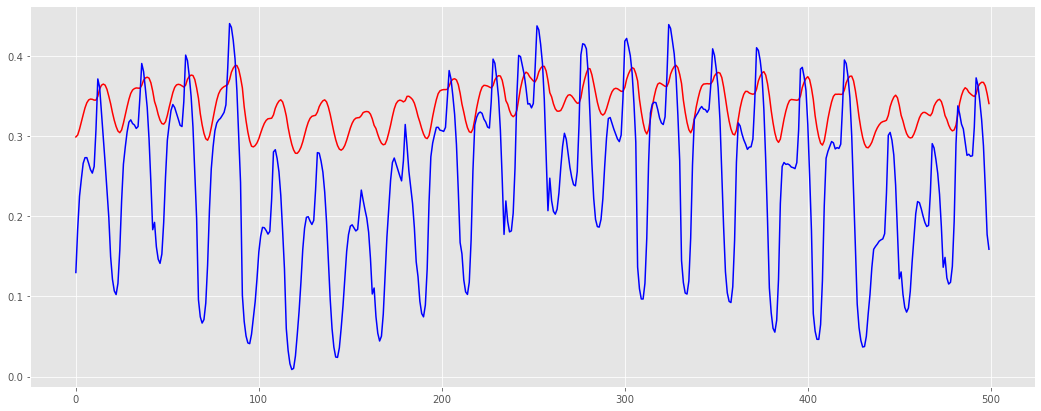

In [83]:
plt.figure(figsize=(18,7))
plt.plot(predict[0:500],'r')
plt.plot(y_test[0:500],'b')
#plt.plot(temp[0:500],'k')

Tune the model parameters such as changing an optimizer, reduce or increase the model layers...etc

In [84]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(40,return_sequences=True,input_shape=(1, look_back))) #input_shape=(1, look_back), input_shape=(X_train.shape[1],1)
model.add(tf.keras.layers.LSTM(40,return_sequences=False))
#model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
# This builds the model for the first time:
model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
3561/3561 [==============================] - 14s 4ms/step - loss: 0.0020
Epoch 2/5
3561/3561 [==============================] - 14s 4ms/step - loss: 5.4364e-04
Epoch 3/5
3561/3561 [==============================] - 14s 4ms/step - loss: 5.2373e-04
Epoch 4/5
3561/3561 [==============================] - 14s 4ms/step - loss: 5.1481e-04
Epoch 5/5
3561/3561 [==============================] - 14s 4ms/step - loss: 5.0826e-04


In [85]:
yhat = model.predict(X_test)

In [75]:
predict = np.zeros(len(X_test))
for i in range(len(X_test)):
# predict scaled value for next time step
    temp = yhat[i][0]
    predict[i] = temp
    
'''temp = np.zeros(len(X_test))
for i in range(len(X_test)):
# predict scaled value for next time step
    a = X_test[i][0]
    temp[i] = a    
'''

'temp = np.zeros(len(X_test))\nfor i in range(len(X_test)):\n# predict scaled value for next time step\n    a = X_test[i][0]\n    temp[i] = a    \n'

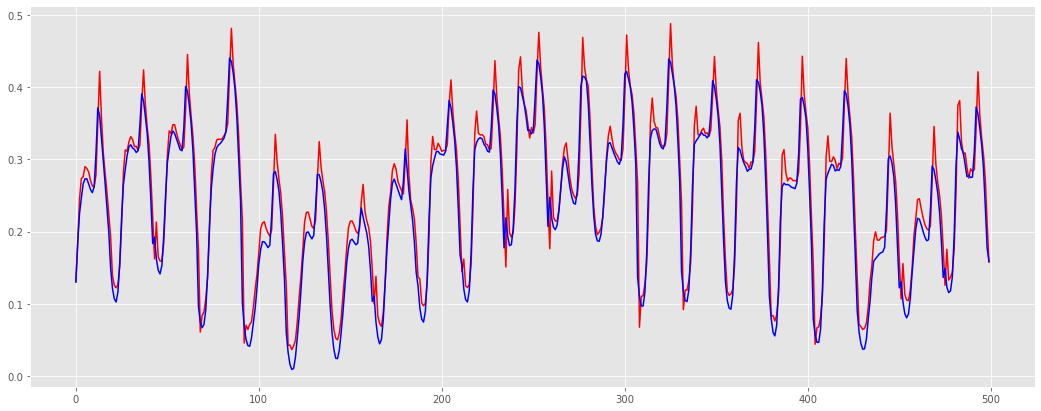

In [76]:
plt.figure(figsize=(18,7))
plt.plot(predict[0:500],'r')
plt.plot(y_test[0:500],'b')
#plt.plot(temp[0:500],'k')

In [ ]:
'''# instantiate a sequential model

model = Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))

'''
#Adapt to run with Tensor flow 2.2

# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix

''''# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=batch_size

# instantiate a sequential model
#model = tf.keras.Sequential()
model = Sequential()


# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=num_neurons,return_sequences=False))

#model.add(tf.keras.layers.LSTM(units=num_neurons,batch_input_shape=batch_input_shape,stateful=True))
# followed by a dense layer with a single output for regression
#model. add(tf.keras.layers.Dense(1))
model.add(Dense(1))
# compile
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(X_train, y_train, batch_size=32, epochs=10)
'''

## References

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
https://towardsdatascience.com/data-pre-processing-techniques-you-should-know-8954662716d6

